In [2]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation
import jax

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

from HOSim import solver
f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6))

eta_hat, phi_hat, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None, None

with h5py.File("Z:\\files\\simulation_1d_compressed.h5", "r") as data:
    eta_hat = data["eta_hat"][:]
    phi_hat = data["phi_hat"][:]
    Hs = data["Hs"][:]
    Tp = data["Tp"][:]
    time = data["time"][:]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

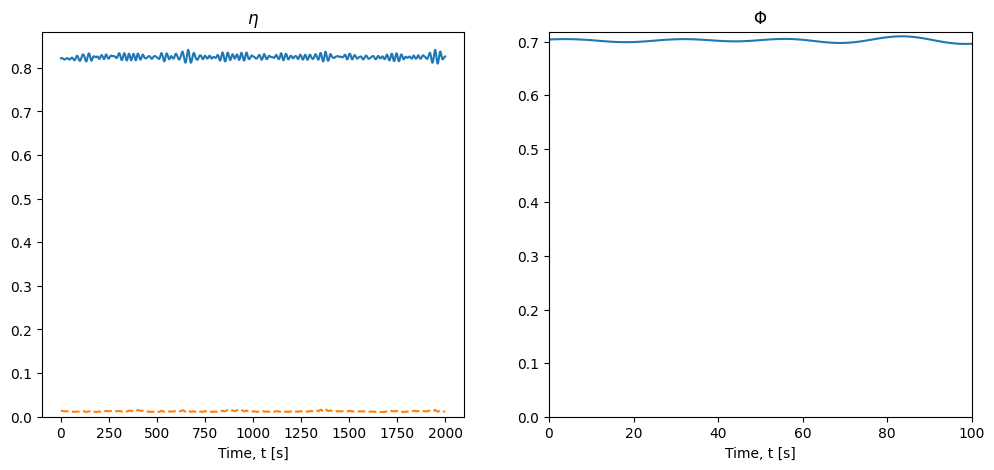

In [122]:
from jax import vmap, jit #f(t, y, modes, g, k0, mHOS, Ta)
from HOSim import solver
from functools import partial

f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6))
f_partial = lambda y: f_jit(200, y, modes, 9.81, 2*np.pi/length, 8, 0.001)
f_vec = jit(vmap(f_partial, in_axes=(0)))

K_eta_avg = []
K_phi_avg = []

k0 = 2*np.pi/length
K = np.diag(np.arange(0, modes+1)*k0)
G = np.diag(np.ones(modes+1)*(-g))
A = np.block([[np.zeros_like(K), K], [G, np.zeros_like(G)]])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for index in range(1):
    y = np.concatenate((eta_hat[index, 0:], phi_hat[index, 0:]), axis=-1)
    f = f_vec(y)

    K_eta = np.sqrt(np.sum(np.abs(f[:-1, :modes+1] - f[1:, :modes+1])**2, axis=-1))
    K_eta /= np.sqrt(np.sum(np.abs(y[:-1, :modes+1] - y[1:, :modes+1])**2, axis=-1))
    K_eta_avg.append(np.mean(K_eta))
    axs[0].plot(K_eta)
    
    K_eta = np.sqrt(np.sum(np.abs(f[:-1, :modes+1] - f[1:, :modes+1] - (A @ (y[:-1] - y[1:]).T).T[:, :modes+1])**2, axis=-1))
    K_eta /= np.sqrt(np.sum(np.abs(y[:-1, :modes+1] - y[1:, :modes+1])**2, axis=-1))
    K_eta_avg.append(np.mean(K_eta))
    axs[0].plot(K_eta, "--")
    

    K_phi = np.sqrt(np.sum(np.abs(f[:-1, modes+1:] - f[1:, modes+1:])**2, axis=-1))
    K_phi /= np.sqrt(np.sum(np.abs(y[:-1, modes+1:] - y[1:, modes+1:])**2, axis=-1))
    K_phi_avg.append(np.mean(K_phi))
    axs[1].plot(K_phi)

axs[0].set_ylim(0)
axs[1].set_ylim(0)
axs[1].set_xlim(0, 100)
axs[0].set_xlabel("Time, t [s]")
axs[1].set_xlabel("Time, t [s]")
axs[0].set_title(fr"$\eta$")
axs[1].set_title(fr"$\Phi$")
plt.show()

# plt.plot(Hs, K_eta_avg, 'o')
# plt.show()

# plt.plot(Tp, K_eta_avg, 'o')
# plt.show()

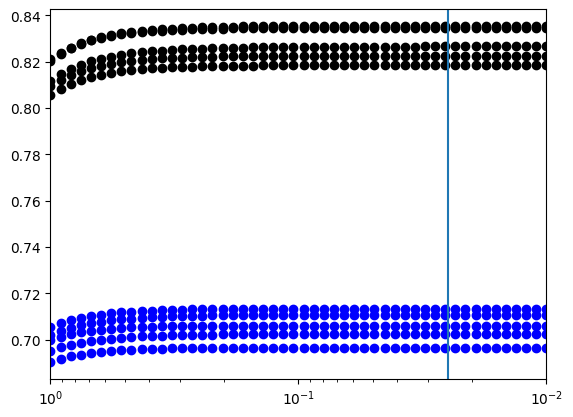

In [8]:
f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6))
rk4 = solver.rk4_step

step_sizes = np.logspace(-2, 0, 50)

for t in range(5):
    for step_size in step_sizes:
        y = np.concatenate((eta_hat[index, 100*t], phi_hat[index, 100*t]))
        y_next = rk4(200, y, step_size, modes, 9.81, 2*np.pi/length, 8, 0.001, f_jit)

        f = f_jit(200, y, modes, 9.81, 2*np.pi/length, 8, 0.001)
        f_next = f_jit(200, y_next, modes, 9.81, 2*np.pi/length, 8, 0.001)

        K_eta = np.sqrt(np.sum(np.abs(f[:modes+1] - f_next[:modes+1])**2)) / np.sqrt(np.sum(np.abs(y[:modes+1]-y_next[:modes+1])**2))
        plt.semilogx(step_size, K_eta, 'o', color="k")

        K_phi = np.sqrt(np.sum(np.abs(f[modes+1:] - f_next[modes+1:])**2)) / np.sqrt(np.sum(np.abs(y[modes+1:]-y_next[modes+1:])**2))
        plt.semilogx(step_size, K_phi, 'o', color="b")

plt.xlim(np.max(step_sizes), np.min(step_sizes))
plt.axvline(0.025)
plt.show()




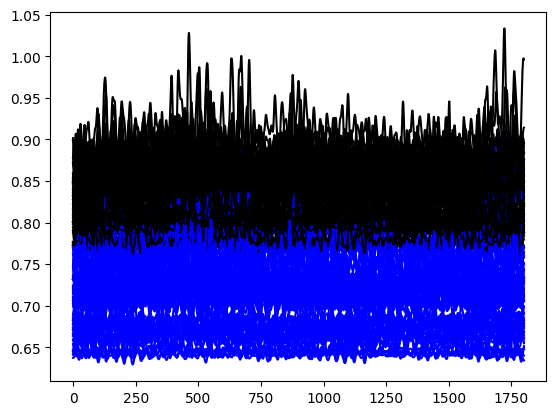

In [104]:
from jax import vmap, jit #f(t, y, modes, g, k0, mHOS, Ta)
from HOSim import solver
from functools import partial

f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6))
f_partial = lambda y: f_jit(200, y, modes, 9.81, 2*np.pi/length, 8, 0.001)
f_vec = jit(vmap(f_partial, in_axes=(0)))

rk4_jit = jax.jit(solver.rk4_step, static_argnums=(0, 2, 3, 4, 5, 6, 7, 8))
rk4_partial = lambda y: rk4(200, y, 0.025, modes, 9.81, 2*np.pi/length, 8, 0.001, f_jit)
rk4_vec = jit(vmap(rk4_partial, in_axes=(0)))
K_eta_avg = []
K_phi_avg = []

for index in range(64):
    y = np.concatenate((eta_hat[index, 200:], phi_hat[index, 200:]), axis=-1)
    y_next = rk4_vec(y)

    f = f_vec(y)
    f_next = f_vec(y_next)

    K_eta = np.sqrt(np.sum(np.abs(f[:, :modes+1] - f_next[:, :modes+1])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :modes+1]-y_next[:, :modes+1])**2, axis=-1))
    plt.plot(K_eta, color="k")

    K_phi = np.sqrt(np.sum(np.abs(f[:, modes+1:] - f_next[:, modes+1:])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, modes+1:]-y_next[:, modes+1:])**2, axis=-1))
    plt.plot(K_phi, color="b")

    K_eta_avg.append(np.mean(K_eta))
    K_phi_avg.append(np.mean(K_phi))
plt.show()

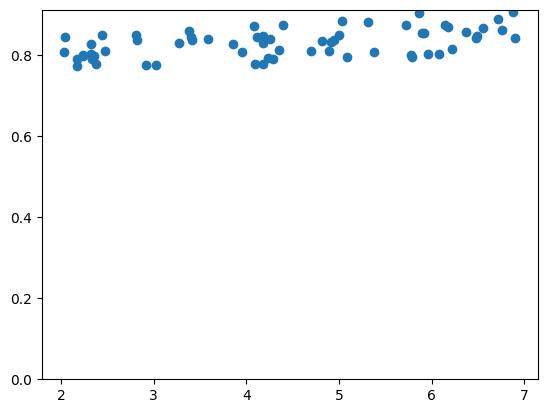

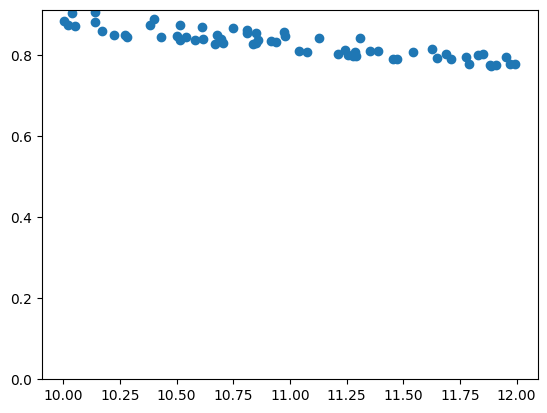

In [106]:
plt.plot(Hs[:len(K_eta_avg)], K_eta_avg, 'o')
plt.ylim(0)
plt.show()

plt.plot(Tp[:len(K_eta_avg)], K_eta_avg, 'o')
plt.ylim(0)
plt.show()

In [121]:
import plotly.graph_objects as go

# Trim arrays to the same length
Hs_trim = Hs[:len(K_eta_avg)]
Tp_trim = Tp[:len(K_eta_avg)]
K_trim = K_eta_avg+K_phi_avg

fig = go.Figure(data=[go.Scatter3d(
    x=Hs_trim,
    y=Tp_trim,
    z=K_trim,
    mode='markers',
    marker=dict(
        size=5,
        color=K_trim,            # Color points by K_eta_avg
        colorscale='Viridis',    # Choose color scale
        colorbar=dict(title='K_eta_avg'),
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Hs [m]',
        yaxis_title='Tp [s]',
        zaxis_title='K_eta_avg'
    ),
    title='3D Scatter Plot of K_eta_avg vs Hs and Tp',
    width=800,
    height=600
)

fig.show()


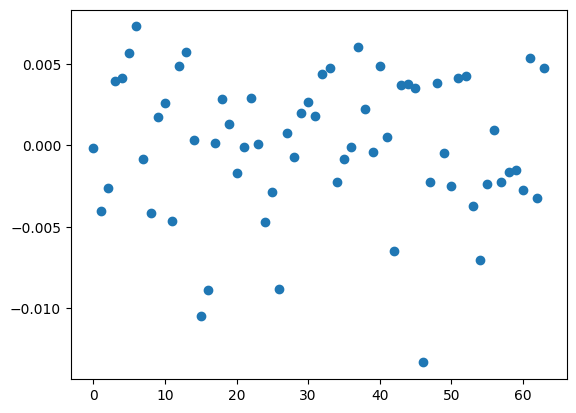

0.009585657093830491 -0.002244208832667659 1.060394843892259


In [120]:
import numpy as np
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

# Trim inputs
Hs_trim = Hs[:len(K_eta_avg)]
Tp_trim = Tp[:len(K_eta_avg)]
K_trim = K_eta_avg

# Prepare input for regression
X = np.column_stack((Hs_trim, Tp_trim**2))  # shape (n_samples, 2)
y = K_trim

# Fit linear regression plane: K ≈ a*Hs + b*Tp + c
model = LinearRegression().fit(X, y)
a, b = model.coef_
c = model.intercept_

# Generate meshgrid for the plane
Hs_range = np.linspace(min(Hs_trim), max(Hs_trim), 30)
Tp_range = np.linspace(min(Tp_trim), max(Tp_trim), 30)
Hs_grid, Tp_grid = np.meshgrid(Hs_range, Tp_range)

# Interpolated K values from plane equation
K_grid = a * Hs_grid + b * Tp_grid**2 + c

plt.plot(a * Hs + b * Tp**2 + c - K_eta_avg, "o")
plt.show()

print(a, b, c)

fig = go.Figure()

# Original points
fig.add_trace(go.Scatter3d(
    x=Hs_trim,
    y=Tp_trim,
    z=K_trim,
    mode='markers',
    marker=dict(size=5, color=K_trim, colorscale='Viridis', colorbar=dict(title='K_eta_avg')),
    name='Data'
))

# Fitted surface
fig.add_trace(go.Surface(
    x=Hs_range,
    y=Tp_range,
    z=K_grid,
    colorscale='Viridis',
    opacity=0.5,
    name='Interpolated Plane'
))

fig.update_layout(
    scene=dict(
        xaxis_title='Hs [m]',
        yaxis_title='Tp [s]',
        zaxis_title='K_eta_avg'
    ),
    title='K_eta_avg Plane Fit',
    width=800,
    height=600
)

fig.show()


In [105]:
gamma = 3.5
g = 9.81
length = 3000
modes = 512
mHOS = 6

Hs_list = np.linspace(0.5, 8, 16) # 0.5 to 8
Tp_list = np.linspace(8, 15, 15)

y = np.zeros((16, 15, 1026), dtype=complex)
for i, Hs in enumerate(Hs_list):
    for j, Tp in enumerate(Tp_list):
        k0 = 2 * np.pi / length
        T1 = 0.834 * Tp
        k = np.arange(1, modes+1)*k0
        w = np.sqrt(k * g)

        sigma = 0.07 * (w <= 5.24/T1) + 0.09 * (w > 5.24/T1)
        Sw = (155 * Hs**2 / T1**4 / w**5 *
            np.exp(-944 / (T1*w)**4) *
            gamma ** np.exp(-((0.191*w*T1 - 1)/(np.sqrt(2)*sigma))**2))
        Sk = Sw * g / (2 * np.sqrt(k * g))

        phases = np.exp(np.random.rand(modes)*2*np.pi*1.j)
        eta_hat_ = np.sqrt(Sk * k0 * 0.5) * phases * 2 * modes
        phi_hat_ = eta_hat_ * np.exp(-1.j * np.pi / 2) * np.sqrt(g / k)

        alias_mask = np.arange(modes+1) < modes * 2 / (mHOS + 1)

        eta_hat_ = np.insert(eta_hat_, 0, 0) * alias_mask
        phi_hat_ = np.insert(phi_hat_, 0, 0) * alias_mask

        y[i, j] = np.concatenate((eta_hat_, phi_hat_))

In [121]:
f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6)) #f(t, y, modes, g, k0, mHOS, Ta):
f_partial = lambda t, y: f_jit(t, y, modes, 9.81, 2*np.pi/length, 8, 50)
f_nested_vec = jax.jit(jax.vmap(jax.vmap(f_partial, in_axes=(None, 0)), in_axes=(None, 0)))

rk4_jit = jax.jit(solver.rk4_step, static_argnums=(0, 2, 3, 4, 5, 6, 7, 8)) #rk4_step(t, y, h, modes, g, k0, mHOS, Ta, f_jit):
rk4_partial = lambda t, y: rk4(t, y, 0.025, modes, 9.81, 2*np.pi/length, 8, 50, f_jit)
rk4_nested_vec = jax.jit(jax.vmap(jax.vmap(rk4_partial, in_axes=(None, 0)), in_axes=(None, 0)))
K_eta_avg = []
K_phi_avg = []

steps = 100
step_size = 0.025

K_eta_total = np.zeros((*y.shape[:2], steps//20))
K_phi_total = np.zeros((*y.shape[:2], steps//20))

K_eta_nonlin = np.zeros((*y.shape[:2], steps//20))
K_phi_nonlin = np.zeros((*y.shape[:2], steps//20))

f = f_nested_vec(0, y)
for i, t in enumerate(np.arange(0, steps)*step_size):
    y_next = rk4_nested_vec(t, y) #t
    f_next = f_nested_vec(t+step_size, y) #t + step_size

    B = (y - y_next).reshape(-1, A.shape[1]) 
    result = B @ A.T 
    K_lin = result.reshape(y.shape) 
    K_lin_eta = K_lin[:, :, :modes+1]
    K_lin_phi = K_lin[:, :, modes+1:]

    if (i+1) % 20 == 0:
        K_eta_nonlin[:, :, (i+1)//20-1] = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1] - K_lin_eta)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
        K_phi_nonlin[:, :, (i+1)//20-1] = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:] - K_lin_phi)**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))

        K_eta_total[:, :, (i+1)//20-1] = np.sqrt(np.sum(np.abs(f[:, :, :modes+1] - f_next[:, :, :modes+1])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, :modes+1]-y_next[:, :, :modes+1])**2, axis=-1))
        K_phi_total[:, :, (i+1)//20-1] = np.sqrt(np.sum(np.abs(f[:, :, modes+1:] - f_next[:, :, modes+1:])**2, axis=-1)) / np.sqrt(np.sum(np.abs(y[:, :, modes+1:]-y_next[:, :, modes+1:])**2, axis=-1))
    
    y = y_next
    f = f_next

[0.02564408 0.02564408 0.02564408 0.02564407 0.02564407 0.02564409
 0.02564412 0.02564412 0.0256441  0.02564409 0.02564418 0.02564432
 0.02564435 0.02564421 0.02564403]
[0.02564408 0.02564408 0.02564408 0.02564407 0.02564407 0.02564409
 0.02564412 0.02564412 0.0256441  0.02564409 0.02564418 0.02564432
 0.02564435 0.02564421 0.02564403]
[0.9920054  0.9920054  0.9920054  0.9920054  0.99200541 0.99200544
 0.99200545 0.99200545 0.99200548 0.99200559 0.99200571 0.99200566
 0.99200544 0.99200525 0.99200528]


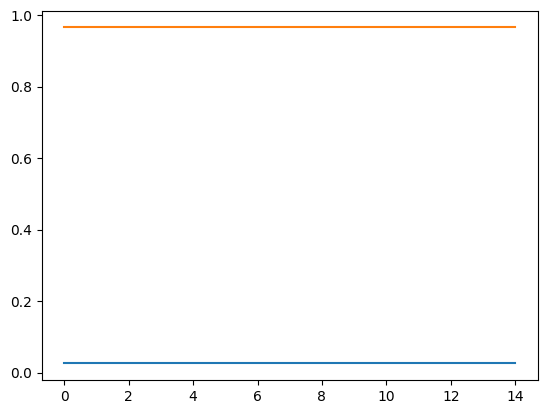

In [118]:
plt.plot(K_eta[0, 0])
# plt.ylim(0.95, 0.97)

print(K_eta[0, 0])

plt.plot(K_eta_lin[0, 0])



print(K_eta[0, 0])

print(K_eta[0, 0] + K_eta_lin[0, 0])

In [68]:
K = np.diag(np.arange(0, modes+1)*k0)
G = np.diag(np.ones(modes+1)*(-g))
A = np.block([[np.zeros_like(K), K], [G, np.zeros_like(G)]])

rk4_partial = lambda t, y: rk4(t, y, 0.01, modes, 9.81, 2*np.pi/length, 8, 50, f_jit)

i_1 = 600
i_2 = 1000
y = np.concatenate((eta_hat[0, i_2], phi_hat[0, i_1]))
y_next = rk4_partial(0, y)

K_1 = np.sum(np.abs(A @ y)**2)
K_2 = np.sum(np.abs(A @ y_next)**2)

ratio = np.sum(np.abs(A @ (y - y_next))**2) / np.sum(np.abs(y - y_next)**2)
print(ratio)





0.4947890242815438
